In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Initializing Metal backend
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Importing dataset
# Data available here : https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption
household_power_consumption = pd.read_csv(
    "household_power_consumption.txt",
    sep = ";", parse_dates = {"datetime":["Date", "Time"]}, low_memory = False, 
    na_values = ["nan", "?"])

# Set datetime as index
household_power_consumption.set_index("datetime", inplace = True)

# Checking for NaN values
household_power_consumption.isna().values.any()

# Filling missing values
household_power_consumption.interpolate(inplace = True)

# Normalizing variables
scaler = MinMaxScaler()
household_pc_scaled = scaler.fit_transform(household_power_consumption)

# Putting normalized data in a DataFrame
household_pc_scaled = pd.DataFrame(household_pc_scaled,
                                   columns=household_power_consumption.columns, 
                                   index=household_power_consumption.index)

# Splitting our sample
household_pc_training = household_pc_scaled.sample(frac = 0.8, random_state = 123456)
household_pc_validation = household_pc_scaled.drop(household_pc_training.index)

# Creating sequences for time-series forecasting
def create_sequences(data, seq_length):
    """
    _summary_
    This function creates sequences with a fixed length to use as input in a model.
    It allows us to use the past n (as set by seq_length) observations to predict the n+1 one.
    The n observations are stored in xs, the n+1 one is stored in ys.

    Args:
        data (pd.DataFrame): input data
        seq_length (int): length of data used to predict the next value

    Returns:
        np.array, np.array: two arrays containing the sequences
    """    
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length]["Global_active_power"]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Generating the sequences
seq_n = 24
X_train, y_train = create_sequences(household_pc_scaled.drop(household_pc_validation.index), seq_n)
X_test, y_test = create_sequences(household_pc_validation, seq_n)

# Converting data to PyTorch tensors
X_train_tensors = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensors = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32).to(device)

# Creating data loaders
hh_pc_train = TensorDataset(X_train_tensors, y_train_tensors)
hh_pc_test = TensorDataset(X_test_tensors, y_test_tensors)
train_loader = DataLoader(hh_pc_train, batch_size=64, shuffle=True)
test_loader = DataLoader(hh_pc_test, batch_size=64, shuffle=False)

/var/folders/h1/hrjhnsw55w3fh7wq8fc7_bcm0000gn/T/ipykernel_1137/2621796662.py:18: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  household_power_consumption = pd.read_csv(


In [ ]:
# Model construction
class EnergyConsumptionModel(nn.Module):
    def __init__(self, input_dim):
        super(EnergyConsumptionModel, self).__init__()
        self.fc0 = nn.Linear(input_dim, 100)
        self.fc1 = nn.Linear(100, 50)
        self.lstm1 = nn.LSTM(50, 50, batch_first=True)
        self.dropout = nn.Dropout(0.25)
        self.bn = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, 1)

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        lstm_out, _ = self.lstm1(x)
        lstm_out = lstm_out[:, -1, :] # Output extraction from LSTM layer
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.bn(lstm_out)
        x = F.relu(self.fc2(lstm_out))
        out = self.fc3(x)
        return out

# Initialization
model = EnergyConsumptionModel(X_train.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=5)

# Model training
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs = 20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        scheduler.step(avg_loss)

train_model(model, train_loader, criterion, optimizer, scheduler, epochs=50)

# Model evaluation
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.append(outputs.squeeze().cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    mse = mean_squared_error(actuals, predictions)
    print(f"Test MSE: {mse}")
    return actuals, predictions, mse

actuals, predictions, mse = evaluate_model(model, test_loader)

# Graphing the results
plt.figure(figsize=(15, 6))
plt.plot(actuals, label="Actuals")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.title("Energy Consumption Forecasting")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.savefig("nn_loss.png")

Epoch 1/50, Loss: 0.0009010808395075919
Epoch 2/50, Loss: 0.0006832155014763273
Epoch 3/50, Loss: 0.0006528048261794014
Epoch 4/50, Loss: 0.0006362979056989979
Epoch 5/50, Loss: 0.0006231122805455548
Epoch 6/50, Loss: 0.0006148620469378081
Epoch 7/50, Loss: 0.0006079577112587047
Epoch 8/50, Loss: 0.0006019563124593182
Epoch 9/50, Loss: 0.000596521514430913
Epoch 10/50, Loss: 0.0005919807101360117
Epoch 11/50, Loss: 0.0005868797766897156
Epoch 12/50, Loss: 0.000582985135677321
Epoch 13/50, Loss: 0.0005801619826410436
Epoch 14/50, Loss: 0.000577361868905058
Epoch 15/50, Loss: 0.000573446018309402
Epoch 16/50, Loss: 0.0005720336472729457
Epoch 17/50, Loss: 0.000570553282401576
Epoch 18/50, Loss: 0.0005683819362098576
Epoch 19/50, Loss: 0.0005666210603981051
Epoch 20/50, Loss: 0.0005643350128641911
Epoch 21/50, Loss: 0.0005629249126075182
Epoch 22/50, Loss: 0.0005627217165766351
Epoch 23/50, Loss: 0.000560680980520996
Epoch 24/50, Loss: 0.0005603657263804537
Epoch 25/50, Loss: 0.0005580664

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [30]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.append(outputs.squeeze().cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    mse = mean_squared_error(actuals, predictions)
    print(f"Test MSE: {mse}")
    return actuals, predictions, mse

actuals, predictions, mse = evaluate_model(model, test_loader)


Test MSE: 0.001979818567633629


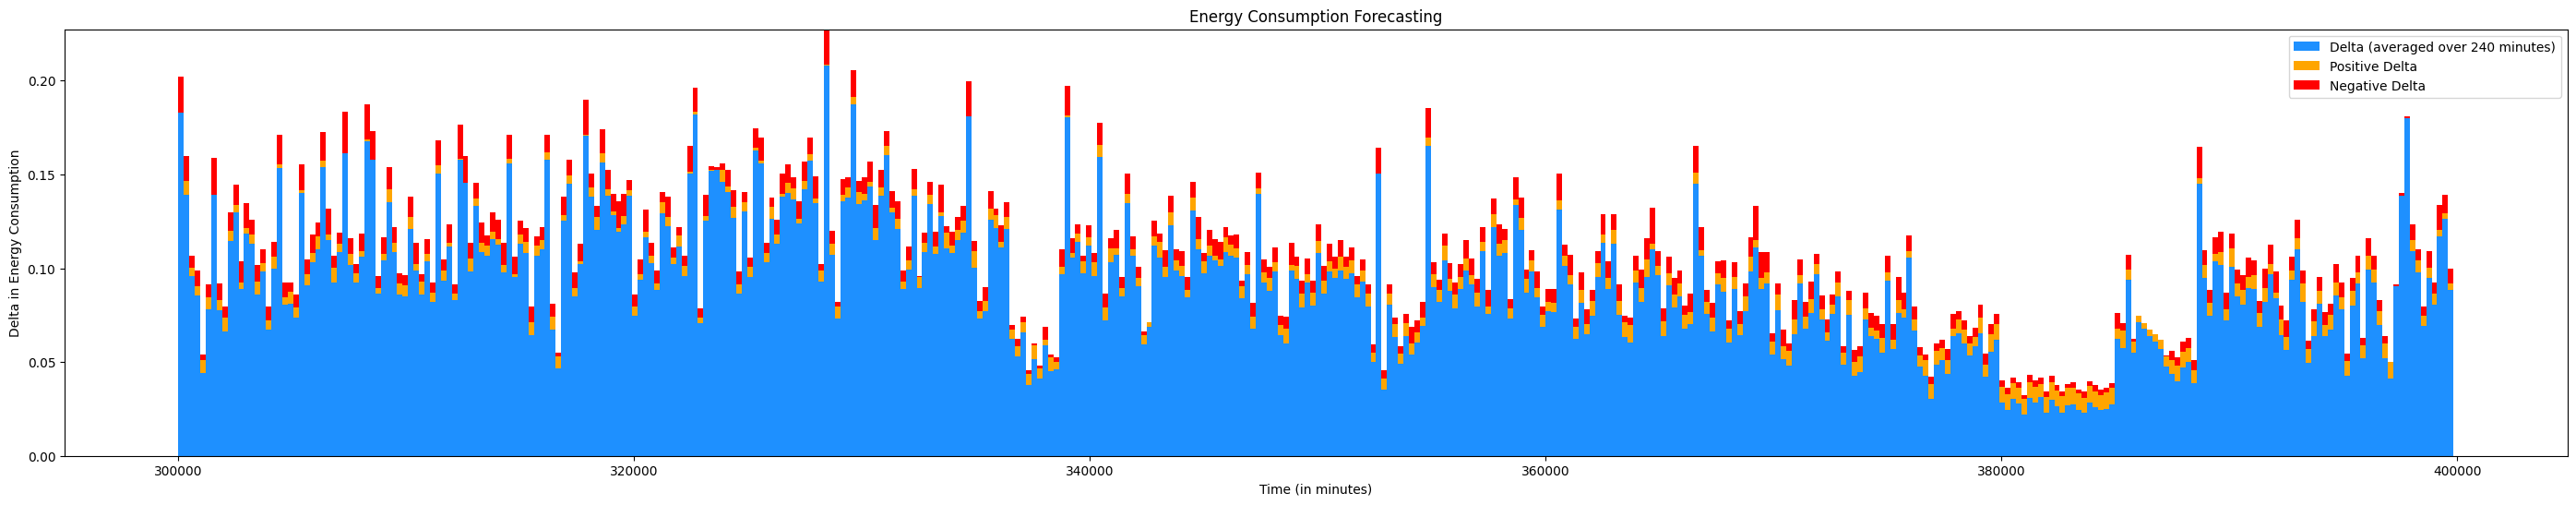

In [70]:
delta = predictions - actuals
x_start = 300_000
x_end = 400_000
delta_slice = delta[x_start:x_end]
actuals_slice = actuals[x_start:x_end]
positive_delta = np.maximum(delta_slice, 0)
negative_delta = np.minimum(delta_slice, 0)
x_values = range(x_start, x_end)

# Grouping data in chunks
chunk_size = 240
num_chunks = len(delta_slice) // chunk_size
averaged_actuals = [np.mean(actuals_slice[i * chunk_size:(i+1) * chunk_size]) for i in range(num_chunks)]
averaged_deltas = [np.mean(delta_slice[i*chunk_size:(i+1)*chunk_size]) for i in range(num_chunks)]
averaged_positive_deltas = [np.mean(positive_delta[i * chunk_size:(i+1) * chunk_size]) for i in range(num_chunks)]
averaged_negative_deltas = [np.mean(negative_delta[i * chunk_size:(i+1) * chunk_size]) for i in range(num_chunks)]
x_values = range(x_start, x_start + num_chunks * chunk_size, chunk_size)

# Graphing the results
plt.figure(figsize=(35, 6))
plt.bar(x_values, averaged_actuals, width = chunk_size, align="edge", label = f"Delta (averaged over {chunk_size} minutes)", color = "dodgerblue")
plt.bar(x_values, averaged_positive_deltas, width = chunk_size, align="edge", bottom = averaged_actuals, label = "Positive Delta", color = "orange")
plt.bar(x_values, averaged_negative_deltas, width=chunk_size, align="edge", bottom=np.array(averaged_actuals) + np.array(averaged_positive_deltas), label="Negative Delta", color="red")
plt.legend()
plt.title("Energy Consumption Forecasting")
plt.xlabel("Time (in minutes)")
plt.ylabel("Delta in Energy Consumption")
plt.savefig("nn_loss.png")



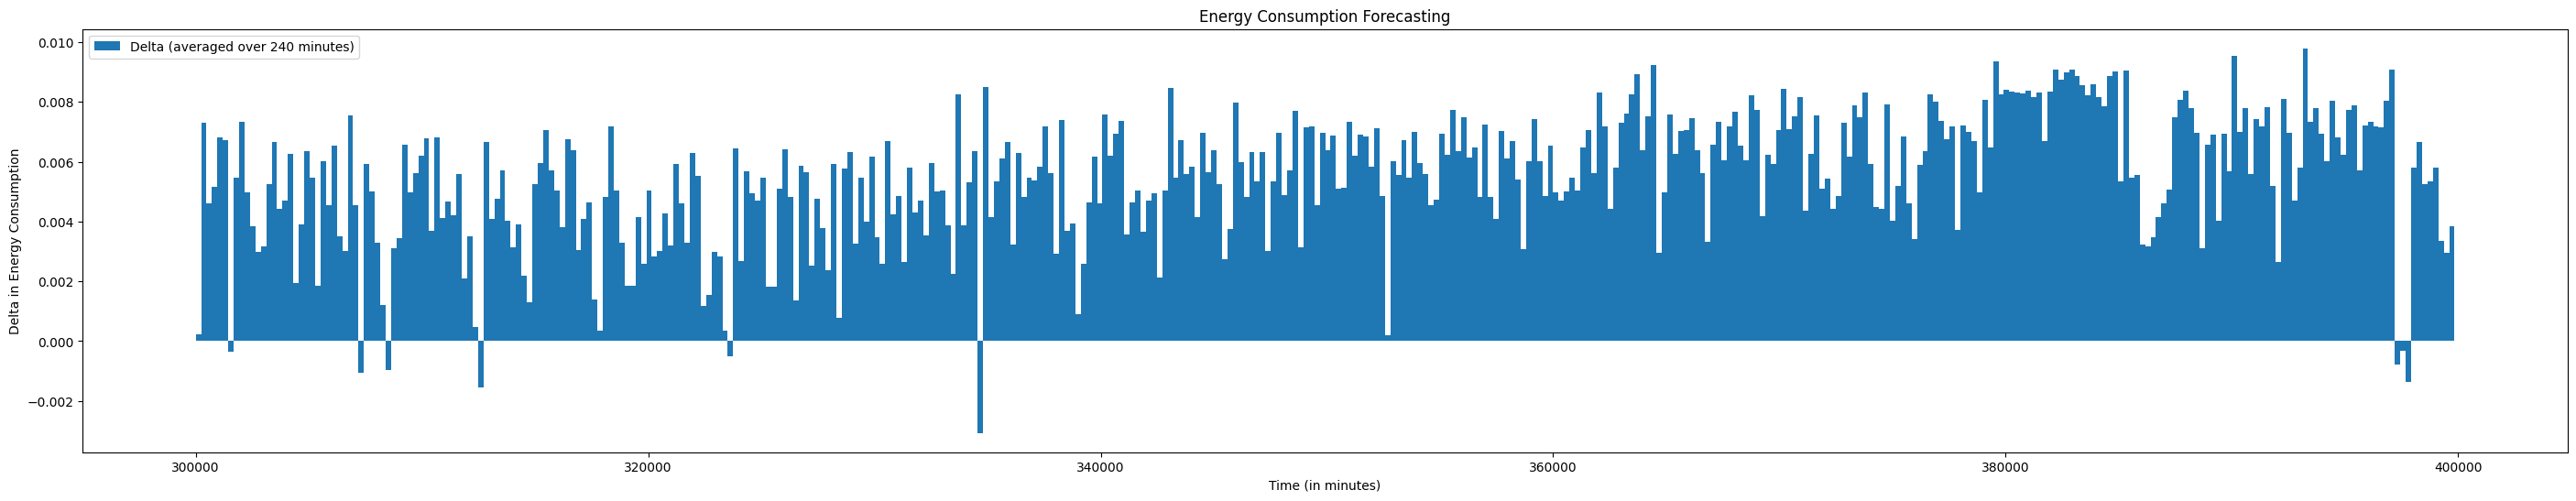

In [71]:
# Graphing the delta
plt.figure(figsize=(35, 6))
plt.bar(x_values, averaged_deltas, width=chunk_size, align="edge", label=f"Delta (averaged over {chunk_size} minutes)")
plt.legend()
plt.title("Energy Consumption Forecasting")
plt.xlabel("Time (in minutes)")
plt.ylabel("Delta in Energy Consumption")
plt.savefig("nn_loss.png")